# Estimating Star Rating of Amazon Reviews from Text
## Ahmad Sesay, Emily Zhao, and Will Schulte


### Introduction

One of the most prominent techniques in the field of Natural Language Processing (NLP) is sentiment analysis. This is the process of extracting and analyzing the emotional information contained within human written text. It is an essential part of automating the large scale analysis of text datasets to understand the meaning that normally only a human could do.

This is why we have chosen to build a machine learning model capable of predicting the 1-5 star rating a customer has given a product just through analysis of the review text. We are going to explore the process of building a sentiment analysis model from what type of data we used, what types of machine learning techniques work well, all the way to applications of the technique. At the end of this tutorial, you should have a clear idea as to how one of these models is made effectively and how it can be used in novel cases.

In the past, this sort of analysis where you try to quantify how much a person enjoyed a product through just what they tell you, was exclusively a human task. The only way to assess how much a product was liked by a large number of people through their reviews was to have them give you their rating themselves or go through it manually. However, the recent explosion in popularity that sites like Amazon have had has drastically increased the amount of applicable training data available as well as the quality of metadata for these reviews as well. This has given us more than enough information needed for machine learning and allowed us to explore the connections of reviews among different product types.

### Data Collection

The task of sentiment analysis through online reviews is already a popular sentiment analysis task. As such, a publicly available UCSD database contains over 230 million Amazon reviews, already prepared with the necessary metadata and organized into 29 product categories. This makes the data collection part of the project much simpler and faster, as the alternative would have pushed us to Amazon’s advertising API or manually having scripts scrape reviews off of Amazon’s website.

Due to the size of these datasets, we decided to train two models. The first model is trained using only reviews from the ‘video game’ category and on top of that we are using a smaller subset of the data that consists of 497,577 reviews in total, still more than enough for our training. The second model is trained using a combined data set of reviews from 4 separate categories,.

Our analysis of the models will involve testing both on multiple review types. Our goal is to see how generalizable the trends that the models learn from one category are to another. For example, do most positive and negative reviews use similar syntax, or would a positive review for a video game look different enough from one for a beauty product to mess up the prediction? Additionally, we are going to investigate how well different machine learning models handle being trained and tested on different categories.


### Data Processing

In the data frame, we filled in any missing data. We then turned the reviews into a string as we having problems processing reviews that utilized numbers. We added a lemmatizer to reduce the words in the text data to their base root works which assisted in increasing the model's accuracy. The data was also normalized so that there was a more even distribution of 1-5 star reviews. 


In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
#Added in lemmantizing-Ahmad
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sesay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sesay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sesay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Dataset for model trained with multiple categories.

# Combining 4 datasets -Ahmad
data_1 = pd.read_json('Video_Games_5.json',lines=True).iloc[0:100000]
data_2 = pd.read_json('Musical_Instruments_5.json',lines=True).iloc[0:100000]
data_3 = pd.read_json('Sports_and_outdoors_5.json',lines=True).iloc[0:100000]
data_4 = pd.read_json('Software_5.json',lines=True).iloc[0:100000]
data = pd.concat([data_1,data_2,data_3,data_4], axis=0, ignore_index=True)

# Normalizing Data
df_majority = data[data['overall'] == 5]
df_minority_4 = data[data['overall'] == 4]
df_minority_3 = data[data['overall'] == 3]
df_minority_2 = data[data['overall'] == 2]
df_minority_1 = data[data['overall'] == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority,  replace=False,  n_samples=len(df_minority_1), random_state=42) # reproducible results

# Upsample minority classes
df_minority_4_upsampled = resample(df_minority_4,  replace=True, n_samples=len(df_majority_downsampled),  random_state=42) # reproducible results

df_minority_3_upsampled = resample(df_minority_3, replace=True, n_samples=len(df_majority_downsampled), random_state=42)

df_minority_2_upsampled = resample(df_minority_2, replace=True, n_samples=len(df_majority_downsampled), random_state=42)

df_minority_1_upsampled = resample(df_minority_1, replace=True, n_samples=len(df_majority_downsampled),random_state=42)

# Combine the upsampled minority class with the downsampled majority class
data_combined= pd.concat([df_majority_downsampled,df_minority_4_upsampled, df_minority_3_upsampled, df_minority_2_upsampled,df_minority_1_upsampled])



#fill in the cols that have nan vals
#we noticed some cols had some nan values
#This process helps to handle NaN (Not a Number)/  null
# values that could cause errors or mislead the analysis later. - Emily

data_combined['vote'] = data_combined['vote'].fillna(0)
data_combined['style'] = data_combined['style'].fillna('Unknown')
#print(data.isnull().sum())
data_combined['reviewText'] = data_combined['reviewText'].astype(str).fillna('')

In [3]:
#Dataset for model trained with videogame category.
data_vid = pd.read_json('Video_Games_5.json',lines=True).iloc[0:400000]


# Normalizing Data
df_majority_v = data_vid[data_vid['overall'] == 5]
df_minority_4_v = data_vid[data_vid['overall'] == 4]
df_minority_3_v = data_vid[data_vid['overall'] == 3]
df_minority_2_v = data_vid[data_vid['overall'] == 2]
df_minority_1_v = data_vid[data_vid['overall'] == 1]

# Downsample majority class
df_majority_downsampled_v = resample(df_majority_v,  replace=False,  n_samples=len(df_minority_1_v), random_state=42) # reproducible results

# Upsample minority classes
df_minority_4_upsampled_v = resample(df_minority_4_v,  replace=True, n_samples=len(df_majority_downsampled_v),  random_state=42) # reproducible results

df_minority_3_upsampled_v = resample(df_minority_3_v, replace=True, n_samples=len(df_majority_downsampled_v), random_state=42)

df_minority_2_upsampled_v = resample(df_minority_2_v, replace=True, n_samples=len(df_majority_downsampled_v), random_state=42)

df_minority_1_upsampled_v = resample(df_minority_1_v, replace=True, n_samples=len(df_majority_downsampled_v),random_state=42)

# Combine the upsampled minority class with the downsampled majority class
data_vid= pd.concat([df_majority_downsampled_v,df_minority_4_upsampled_v, df_minority_3_upsampled_v, df_minority_2_upsampled_v,df_minority_1_upsampled_v])



#fill in the cols that have nan vals
#we noticed some cols had some nan values
#This process helps to handle NaN (Not a Number)/  null
# values that could cause errors or mislead the analysis later. - Emily

data_vid['vote'] = data_vid['vote'].fillna(0)
data_vid['style'] = data_vid['style'].fillna('Unknown')
#print(data.isnull().sum())
data_vid['reviewText'] = data_vid['reviewText'].astype(str).fillna('')

### Exploratory Data Analysis


We initially focused on two machine learning model types for our algorithm: random forests, and logistic regression. The random forest technique is a type of ensemble learning using decision trees, meaning it makes a lot of smaller prediction models from subsets of the training dataset then makes its final prediction based on the most common prediction among the small models. This type of model is very flexible, being able to handle both classification tasks as well as regression, but is also computationally expensive due to the large number of trees that need to be made. Logistic regression, on the other hand, calculates the probabilities that a certain review belongs to each category type then makes its prediction based on the highest probability. This technique is much more lightweight and easier to implement, allowing us to train it faster and under more circumstances. 

Throughout our testing, one of the most interesting issues we faced was bias in our dataset. Whether it is a bias in the dataset we used or a bias in the way people write online reviews, we noticed that there were many more 5 star reviews than any other rating, and by a wide margin. This led to issues with our training using the random forest model where, instead of learning the real trends in the reviews, it would just predict 5 starts most of the time because that was usually right.

![alt text here](https://i.redd.it/6nehkh8gq81d1.png)


The confusion matrix shows the number of predictions made for each combination of true and predicted values. The graph clearly shows that it rarely predicts that a review is not 5 stars, but despite this it gets its prediction right most of the time.

To combat this, we normalized the training data we used so that there was an even proportion of each review type, which led its predictions to be much more applicable:

![alt text here](https://i.redd.it/s6d1f93bq81d1.png)

This graph indicates that not only are the random forest model’s predictions correct most of the time but are evenly distributed between all the star scores indicating less bias. This also highlights a key challenge, ambiguity. Product review scores are subjective, there is not always only one correct score for a given review. The model is more easily able to identify higher and lower scores as people are likely to be more polarizing in their vocabulary and tone, but it is less accurate with 3 star reviews in particular, often mixing them up with 4 star reviews.

The same trend was exhibited by the logistic regression-based model, though with a higher accuracy overall. This influenced our decision to use a logistic regression model for sentiment analysis.

![alt text here](https://i.redd.it/int33fm7q81d1.png)


It is important to mention that while the models trained on the raw data may not have had a much lower accuracy than the ones trained on normalized data, the goal of the project is to be able to identify the trends in the text and extract the meaning, not just recognize global trends in online reviews.



In [4]:
import string

# We start by cleaning each review in the dataset. The 'clean_text' function 
#takes each review and does several things:
# 1. Lemmatization: Simplifies words to their base / root form.
# 2. Lowercasing: Converts all characters to lowercase for uniformity and reducing
#    the complexity for the model b/c it treats words like "The" and "the" the same.
# 3. Removing punctuation: Strips punctuation which usually doesn't contribute 
#    to sentiment in reviews.
#clean the text by removing puncutation stuff, also converting it to lowercase only
#-Emily


def clean_text(text):
    #Added in lementizing -Ahmad
    lemmatizer = WordNetLemmatizer()
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    # remove digits?
   # text = ''.join([char for char in text if not char.isdigit()])
    return text

#data pre processing like tokenizing and stuff, preparing for model
#We cleaned each review by applying clean_text func, which lemmatizes the review
#and also converts to lowercase, removes punctuation,  - Emily
data_vid['cleaned_review'] = data_vid['reviewText'].apply(clean_text)
data_combined['cleaned_review'] = data_combined['reviewText'].apply(clean_text)
#print(data)
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Stop words are commonly used words like "the", "a", "an", "in" that are usually
# ignored in text related analysis b/c they appear often but don't have
# much meaning/weight - Emily
stop_words = set(stopwords.words('english'))

# Tokenization and Stop Word Removal:
# 'word_tokenize' is a function from NLTK that splits text into individual words (tokens).
# This is important as it turns the raw text into structured data suitable for analysis.
# Here we also filter out the stop words to focus on more impactful/important
# # words in the reviews.
# - Emily

data_vid['tokens'] = data_vid['cleaned_review'].apply(lambda x: [word for word in word_tokenize(x) if word not in stop_words])
data_combined['tokens'] = data_combined['cleaned_review'].apply(lambda x: [word for word in word_tokenize(x) if word not in stop_words])


### Logistic Regression Training and Data:

When training the logistic regression models, we utilized two methods. The first method was to train the model on Video game reviews and the second was to train the model on a combined dataset of reviews from four separate categories.

When adjusting parameters for the vectorizer, we experimented with the parameters,

Max Features: controls the maximum number of unique terms considered.
Ngram_range: captures more context in texts.
Min_df: ignores terms that appear in less than a percentage of reviews.
Max_df: ignores terms that appear in more than a percentage of reviews.

The Min_df and Max_df were set back to the default numbers as their inclusion decreased the model's accuracy. 

For analysis purposes, we introduced a second way of taking the model's accuracy to showcase its capabilities. Since we observed that a majority of the time the models would either accurately predict the rating or be off by 1, we implemented a separate scoring method that provides the accuracy based on these observations. This now meant that if the model predicted 1 off from the actual answer, it would still be counted as correct. This addition is not a replacement for finding the actual accuracy but does showcase how the model can handle the ambiguity that comes with reviews. 

While training, the data was split into validation and test sets to gain better tune hyperparameters and prevent overfitting.

After training and testing were completed, we took note of the accuracy, cross-validation accuracy, our custom accuracy, and the confusion matrix provided. The cross-validation accuracy utilized k-1 folds to determine how good the model was at predicting new data during validation.


Validation Accuracy: 0.6616602726308056
 Custome Validation Accuracy: 0.913680515876255
Validation Classification Report:
              precision    recall  f1-score   support

           1       0.79      0.79      0.79      4992
           2       0.70      0.71      0.70      4910
           3       0.60      0.59      0.59      4902
           4       0.55      0.54      0.54      4819
           5       0.66      0.67      0.66      4879

    accuracy                           0.66     24502
   macro avg       0.66      0.66      0.66     24502
weighted avg       0.66      0.66      0.66     24502

Validation Confusion Matrix:
[[3967  582  254   87  102]
 [ 539 3487  584  192  108]
 [ 287  641 2873  750  351]
 [  92  184  794 2614 1135]
 [ 109   98  251 1150 3271]]
Validation Loss: 0.9206781170789093


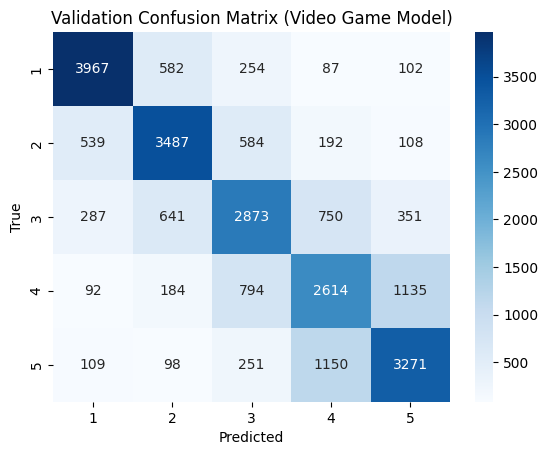

Cross-Validation Accuracy Scores: [0.55587299 0.55289364 0.55166925 0.55481185 0.55219982]
Mean Cross-Validation Accuracy: 0.5534895110603216
Test Accuracy: 0.6631703534405354
Custome Test Accuracy: 0.9118847441025223
Test Classification Report:
              precision    recall  f1-score   support

           1       0.79      0.79      0.79      4747
           2       0.70      0.72      0.71      4871
           3       0.60      0.59      0.59      4957
           4       0.56      0.55      0.55      4963
           5       0.67      0.68      0.67      4964

    accuracy                           0.66     24502
   macro avg       0.66      0.66      0.66     24502
weighted avg       0.66      0.66      0.66     24502

Test Confusion Matrix:
[[3745  559  248   85  110]
 [ 540 3500  541  165  125]
 [ 278  618 2903  800  358]
 [ 110  204  817 2735 1097]
 [  87   95  294 1122 3366]]


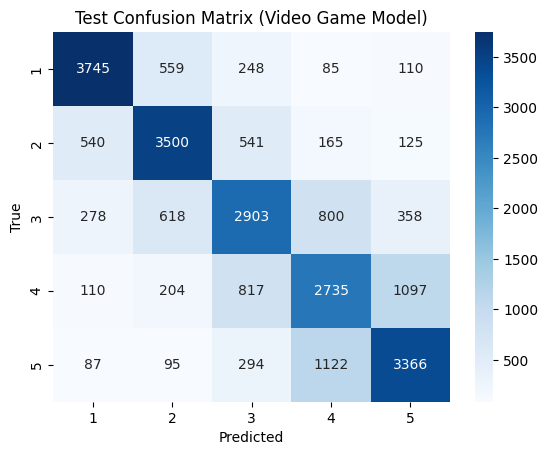

Predicted Rating for New Review: 1 out of 5


In [5]:
# Video Game Model Training

#feature extraction, vectorize the features
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize a TfidfVectorizer:
# 'max_features' is set to 9000, allowing the vectorizer to consider up to 9000
# unique words while turning text to features.

# 'ngram_range' is set to (1, 2) since it will consider single words and 2-word 
# combinations.
# 'min_df' and 'max_df' control the terms included based on their dataset frequency.
# No terms are ignored based on frequency but this setup helps in
# including all words
# regardless  of their occurrence across the dataset.

tfidf_vectorizer_v = TfidfVectorizer(max_features=150000 , ngram_range=(1, 2), min_df=1, max_df=0.1)
features = tfidf_vectorizer_v.fit_transform(data_vid['cleaned_review'])



#MODEL TRAINING
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,log_loss,make_scorer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline

#Creates a way to measeure Accuracy. The prediction is considerted correct if it was off by 1.
def within_1_accuracy(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) <= 1)

within_1_scorer = make_scorer(within_1_accuracy)

#Splitting data in validation and testing data
X_temp, X_test, y_temp, y_test = train_test_split(features, data_vid['overall'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)


#model = model = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)

model = LogisticRegression( C = 20 ,max_iter=1000, multi_class= "multinomial", class_weight='balanced', random_state=42)
model.fit(X_train, y_train)


# Validation
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
custome_val_accuracy = within_1_accuracy(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred, target_names=[str(i) for i in range(1, 6)])
val_conf_matrix = confusion_matrix(y_val, y_val_pred)
val_loss = log_loss(y_val, model.predict_proba(X_val))

print(f"Validation Accuracy: {val_accuracy}")
print(f" Custome Validation Accuracy: {custome_val_accuracy}")
print(f"Validation Classification Report:\n{val_report}")
print(f"Validation Confusion Matrix:\n{val_conf_matrix}")
print(f"Validation Loss: {val_loss}")

# Visualize Validation Confusion Matrix
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(1, 6)], yticklabels=[str(i) for i in range(1, 6)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Validation Confusion Matrix (Video Game Model)')
plt.show()

# Cross-Validation utilizes k-1 folds
pipeline = make_pipeline(TfidfVectorizer(max_features=9000), LogisticRegression(max_iter=1000, multi_class="multinomial", class_weight='balanced', random_state=42))
scores = cross_val_score(pipeline, data_vid['cleaned_review'], data_vid['overall'], cv=5)
print(f"Cross-Validation Accuracy Scores: {scores}")
print(f"Mean Cross-Validation Accuracy: {scores.mean()}")


#Evaluate with Test Data
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
custome_test_accuracy = within_1_accuracy(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred, target_names=[str(i) for i in range(1, 6)])
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy}")
print(f"Custome Test Accuracy: {custome_test_accuracy}")
print(f"Test Classification Report:\n{test_report}")
print(f"Test Confusion Matrix:\n{test_conf_matrix}")

# Visualize test Confusion matrix
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(1, 6)], yticklabels=[str(i) for i in range(1, 6)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix (Video Game Model)')
plt.show()
new_review = ["THIS IS A BAD GAME!"]
new_review_vectorized =tfidf_vectorizer_v.transform(new_review)
predicted_rating = model.predict(new_review_vectorized)


print(f"Predicted Rating for New Review: {predicted_rating[0]} out of 5")


Validation Accuracy: 0.6410019978484709
 Custome Validation Accuracy: 0.9014138619947749
Validation Classification Report:
              precision    recall  f1-score   support

           1       0.76      0.80      0.78      2601
           2       0.69      0.69      0.69      2600
           3       0.57      0.56      0.56      2582
           4       0.53      0.51      0.52      2632
           5       0.65      0.65      0.65      2599

    accuracy                           0.64     13014
   macro avg       0.64      0.64      0.64     13014
weighted avg       0.64      0.64      0.64     13014

Validation Confusion Matrix:
[[2074  283  148   37   59]
 [ 346 1781  302  105   66]
 [ 182  337 1454  433  176]
 [  70  135  490 1331  606]
 [  64   62  179  592 1702]]
Validation Loss: 0.9400214572808274


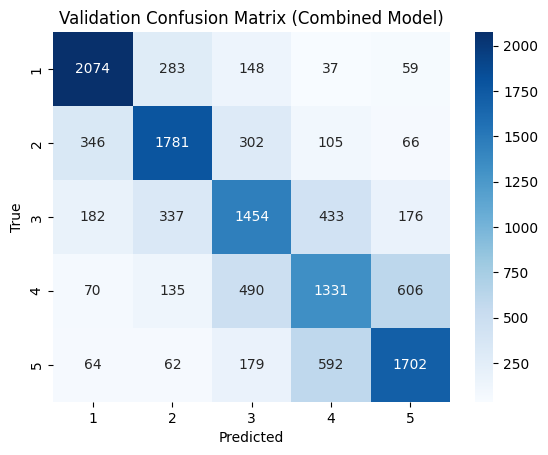

Cross-Validation Accuracy Scores: [0.54541263 0.54241586 0.54548947 0.54226218 0.54925465]
Mean Cross-Validation Accuracy: 0.5449669586599046
Test Accuracy: 0.6244813278008299
Custome Test Accuracy: 0.8970339634240049
Test Classification Report:
              precision    recall  f1-score   support

           1       0.75      0.77      0.76      2601
           2       0.66      0.67      0.66      2638
           3       0.57      0.55      0.56      2649
           4       0.51      0.49      0.50      2547
           5       0.63      0.64      0.63      2579

    accuracy                           0.62     13014
   macro avg       0.62      0.62      0.62     13014
weighted avg       0.62      0.62      0.62     13014

Test Confusion Matrix:
[[2007  349  137   43   65]
 [ 354 1763  333  113   75]
 [ 189  364 1463  436  197]
 [  64  148  462 1249  624]
 [  66   52  191  625 1645]]


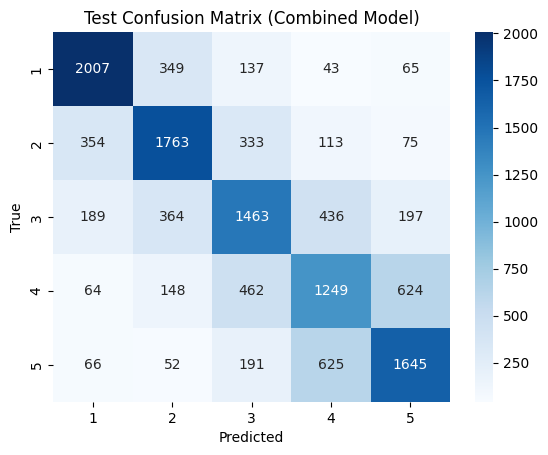

Predicted Rating for New Review: 1 out of 5


In [6]:
# Combined Model Training

#feature extraction, vectorize the features
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize a TfidfVectorizer:
# 'max_features' is set to 150000, allowing the vectorizer to consider up to 150000
# unique words while turning text to features.

# 'ngram_range' is set to (1, 2) since it will consider single words and 2-word 
# combinations.
# 'min_df' and 'max_df' control the terms included based on their dataset frequency.
# No terms are ignored based on frequency but this setup helps in
# including all words
# regardless  of their occurrence across the dataset.

tfidf_vectorizer = TfidfVectorizer(max_features=150000 , ngram_range=(1, 2), min_df=1, max_df=1.0)
features = tfidf_vectorizer.fit_transform(data_combined['cleaned_review'])


#MODEL TRAINING

#Splitting data in validation and testing data
X_temp, X_test, y_temp, y_test = train_test_split(features, data_combined['overall'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

#Random forest model parameters that were used during initial testing.
#model = model = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)

model_c = LogisticRegression( C = 20 ,max_iter=1000, multi_class= "multinomial", class_weight='balanced', random_state=42)
model_c.fit(X_train, y_train)

# Validation
y_val_pred = model_c.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
custome_val_accuracy = within_1_accuracy(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred, target_names=[str(i) for i in range(1, 6)])
val_conf_matrix = confusion_matrix(y_val, y_val_pred)
val_loss = log_loss(y_val, model_c.predict_proba(X_val))

print(f"Validation Accuracy: {val_accuracy}")
print(f" Custome Validation Accuracy: {custome_val_accuracy}")
print(f"Validation Classification Report:\n{val_report}")
print(f"Validation Confusion Matrix:\n{val_conf_matrix}")
print(f"Validation Loss: {val_loss}")

# Visualize Validation Confusion Matrix
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(1, 6)], yticklabels=[str(i) for i in range(1, 6)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Validation Confusion Matrix (Combined Model)')
plt.show()

# Cross-Validation utilizes k-1 folds
pipeline = make_pipeline(TfidfVectorizer(max_features=9000), LogisticRegression(max_iter=1000, multi_class="multinomial", class_weight='balanced', random_state=42))
scores = cross_val_score(pipeline, data_combined['cleaned_review'], data_combined['overall'], cv=5)
print(f"Cross-Validation Accuracy Scores: {scores}")
print(f"Mean Cross-Validation Accuracy: {scores.mean()}")


#Evaluate with Test Data
y_test_pred = model_c.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
custome_test_accuracy = within_1_accuracy(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred, target_names=[str(i) for i in range(1, 6)])
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy}")
print(f"Custome Test Accuracy: {custome_test_accuracy}")
print(f"Test Classification Report:\n{test_report}")
print(f"Test Confusion Matrix:\n{test_conf_matrix}")

# Visualize test Confusion matrix
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(1, 6)], yticklabels=[str(i) for i in range(1, 6)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix (Combined Model)')
plt.show()
new_review = ["THIS IS A BAD GAME!"]
new_review_vectorized =tfidf_vectorizer.transform(new_review)
predicted_rating = model_c.predict(new_review_vectorized)


print(f"Predicted Rating for New Review: {predicted_rating[0]} out of 5")


Accuracy on the new dataset: 0.4263859275053305
Custome Accuracy on the new dataset: 0.8123667377398721


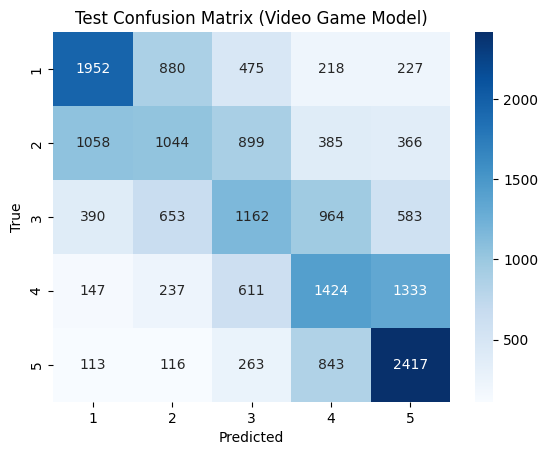

Accuracy on the new dataset: 0.6136460554371003
Custome Accuracy on the new dataset: 0.8933368869936034


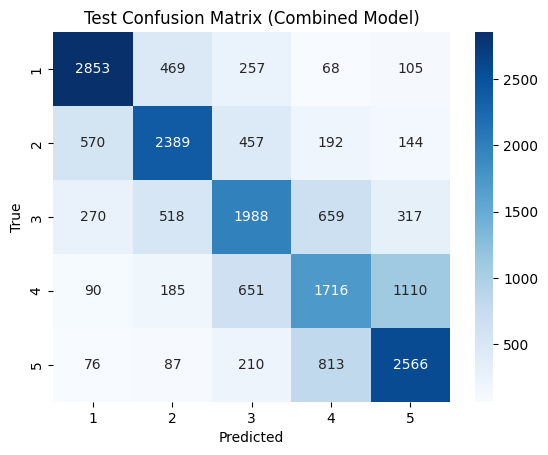

In [7]:
# Model Assesements


# Load the two models model
model_loaded = model
vectorizer_loaded = tfidf_vectorizer_v

multi_model = model_c
multi_vectorizer = tfidf_vectorizer

# Load data and preprosses it.
data = pd.read_json('Sports_and_Outdoors_5.json',lines=True).iloc[0:100000]

df_majority = data[data['overall'] == 5]
df_minority_4 = data[data['overall'] == 4]
df_minority_3 = data[data['overall'] == 3]
df_minority_2 = data[data['overall'] == 2]
df_minority_1 = data[data['overall'] == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority,replace=False, n_samples=len(df_minority_1), random_state=42) # reproducible results

# Upsample minority classes
df_minority_4_upsampled = resample(df_minority_4, replace=True,n_samples=len(df_majority_downsampled),random_state=42) # reproducible results

df_minority_3_upsampled = resample(df_minority_3, replace=True, n_samples=len(df_majority_downsampled), random_state=42)

df_minority_2_upsampled = resample(df_minority_2, replace=True, n_samples=len(df_majority_downsampled), random_state=42)

df_minority_1_upsampled = resample(df_minority_1, replace=True, n_samples=len(df_majority_downsampled), random_state=42)

# Combine the upsampled minority class with the downsampled majority class
data= pd.concat([df_majority_downsampled, df_minority_4_upsampled, df_minority_3_upsampled, df_minority_2_upsampled, df_minority_1_upsampled])

data['reviewText'] = data['reviewText'].astype(str).fillna('')

#data pre-processing like tokenizing and stuff, preparing for model
data['cleaned_review'] = data['reviewText'].apply(clean_text)


# Make predictions on both models and print results
features = vectorizer_loaded.transform(data['cleaned_review'])
multi_features = multi_vectorizer.transform(data['cleaned_review'])

labels = data['overall']
predictions = model_loaded.predict(features)
accuracy = accuracy_score(labels, predictions)
custome_test_accuracy = within_1_accuracy(labels, predictions)
print(f'Accuracy on the new dataset: {accuracy}')
print(f'Custome Accuracy on the new dataset: {custome_test_accuracy}')
test_conf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(1, 6)], yticklabels=[str(i) for i in range(1, 6)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix (Video Game Model)')
plt.show()

# Combined Model Stats
multi_predictions = multi_model.predict(multi_features)
multi_accuracy = accuracy_score(labels, multi_predictions)
multi_custome_test_accuracy = within_1_accuracy(labels, multi_predictions)
print(f'Accuracy on the new dataset: {multi_accuracy}')
print(f'Custome Accuracy on the new dataset: {multi_custome_test_accuracy}')
test_conf_matrix = confusion_matrix(labels, multi_predictions)

sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(1, 6)], yticklabels=[str(i) for i in range(1, 6)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix (Combined Model)')
plt.show()


### Results and Analysis
When testing the two models, we used reviews from five other categories: “Musical Instruments”, “Software”, “Amazon Fashion”, “Patio Lawn and Garden”, and “Sports and Outdoors”. The data below showcases the results of the assessments for both models.


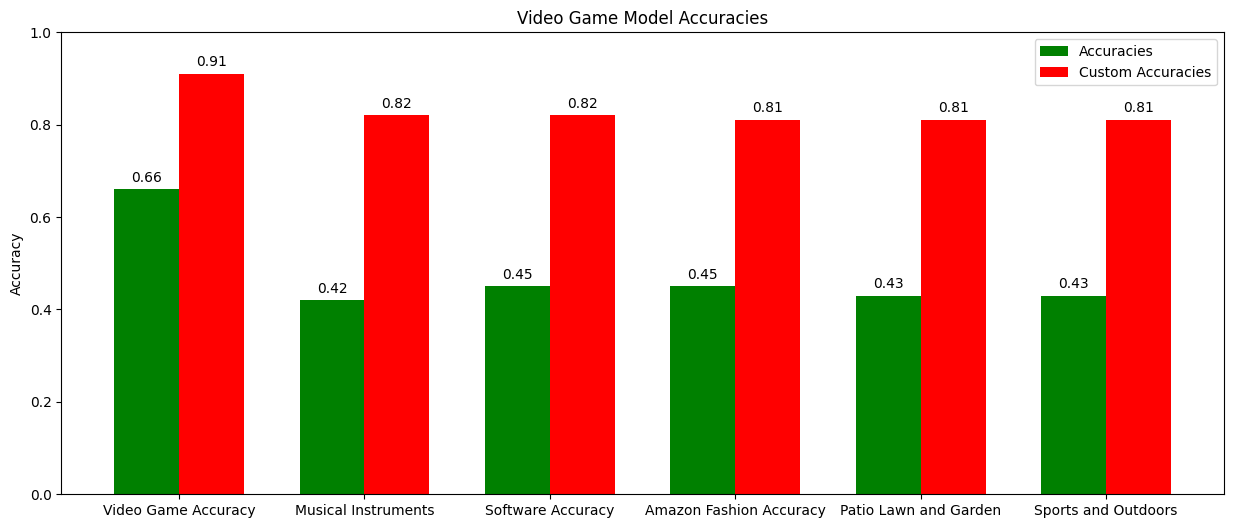

In [8]:

import matplotlib.pyplot as plt
# Labels for the accuracies
labels = ['Video Game Accuracy','Musical Instruments', 'Software Accuracy', 'Amazon Fashion Accuracy', 'Patio Lawn and Garden', 'Sports and Outdoors']
index = np.arange(len(labels))
v_accuracies = [0.66,0.42,0.45,0.45,0.43,0.43]
custome_v_accuracies = [0.91,0.82,0.82,0.81,0.81,0.81]




# Plot data
plt.figure(figsize=(15, 6))
plt.bar(index, v_accuracies, 0.35, label='Accuracies', color='green')
plt.bar(index + 0.35, custome_v_accuracies, 0.35, label='Custom Accuracies', color='red')

# Add numbers to the top of each bar
for i in range(len(index)):
    plt.text(index[i], v_accuracies[i] + 0.01, f'{v_accuracies[i]:.2f}', ha='center', va='bottom')
    plt.text(index[i] + 0.35, custome_v_accuracies[i] + 0.01, f'{custome_v_accuracies[i]:.2f}', ha='center', va='bottom')

#Edit the plot
plt.ylim(0, 1)  
plt.ylabel('Accuracy')
plt.title('Video Game Model Accuracies')
plt.xticks(index + 0.35 / 2, labels)
plt.legend()
plt.show()


The above graph displays the accuracies across all categories for the model trained on only video game reviews. As to be expected the category with the highest accuracy was video games with the predictions in all other categories being relatively the same. This is most likely due to the model understanding patterns and phrases more commonly used with reviewing video games in comparison to other categories. While it is evident that the model requires more tuning, the graph of its accuracies using our custom method revealed more of the model's capabilities.

When we consider observations that are off by 1 to be correct, the accuracy of the model greatly increases. This showcases that while the model is still more proficient at understanding video game reviews, it can get close to the rating a person gives without knowing specific phrases or keywords.  


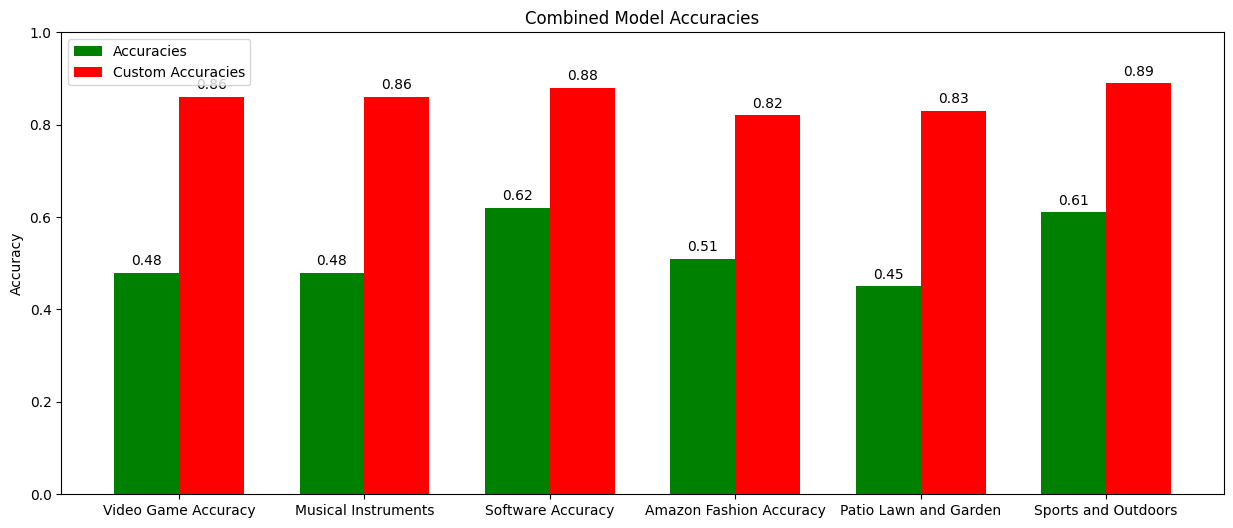

In [9]:
c_accuracies = [0.48,0.48,0.62,0.51,0.45,0.61]
custome_c_accuracies = [0.86,0.86,0.88,0.82,0.83,0.89]

# Plot data
plt.figure(figsize=(15, 6))
plt.bar(index, c_accuracies, 0.35, label='Accuracies', color='green')
plt.bar(index + 0.35, custome_c_accuracies, 0.35, label='Custom Accuracies', color='red')

# Add numbers to the top of each bar
for i in range(len(index)):
    plt.text(index[i], c_accuracies[i] + 0.01, f'{c_accuracies[i]:.2f}', ha='center', va='bottom')
    plt.text(index[i] + 0.35, custome_c_accuracies[i] + 0.01, f'{custome_c_accuracies[i]:.2f}', ha='center', va='bottom')

#Edit the plot
plt.ylim(0, 1)  
plt.ylabel('Accuracy')
plt.title('Combined Model Accuracies')
plt.xticks(index + 0.35 / 2, labels)
plt.legend()
plt.show()


In the model that was trained on multiple review categories, we took entries from the “video games”, “musical instruments”, “sports and outdoors”, and “software” categories. 

The graph above showcases the new accuracies which are more varied than the original model. In comparison the video game and musical instruments files, the software and sports files had less data overall. This could have influenced the accuracy by giving the latter two categories a better distribution of data. Despite this, the model showcases a higher proficiency in predicting ratings from categories outside of the ones used during training. This showcases how important a varied dataset is in increasing model accuracy.

Additionally, In the part of the graph that showcases the model's performance with our custom accuracy method, the model displays a higher proficiency at making close predictions to a wider range of categories. 



### Resources


We hope that, through this tutorial, you are better able to understand the technicalities behind sentiment analysis and the considerations that must be taken when implementing it. While models like this can be very useful in certain circumstances, they need to be handled with care to avoid running into issues like bias in the training data and or data with terminology specific to certain review categories.

If you would like to read more on this use case, there are many online resources showing similar results to our own:
	
[What is Sentiment Analysis](https://aws.amazon.com/what-is/sentiment-analysis/#:~:text=Sentiment%20analysis%20is%20the%20process,social%20media%20comments%2C%20and%20reviews.)
    
[Sentiment of Amazon Reviews](https://medium.com/@eulene.tech/sentiment-analysis-of-amazon-reviews-using-natural-language-processing-6ecb3e253a5e)
    
[Sentiment Analysis using Python](https://www.analyticsvidhya.com/blog/2022/07/sentiment-analysis-using-python/)

Additionally there is much more technical information not covered in this tutorial as well as more uses for sentiment analysis overall:
[Sentiment Analysis on Large Scale](https://www.researchgate.net/publication/325756171_Sentiment_analysis_on_large_scale_Amazon_product_reviews)

[Sentiment Analysis Techniques](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9454799/)